# Equity Backtesting with YFinance Data Adapter

This notebook demonstrates using the YFinanceAdapter to fetch stock data and run a simple backtesting strategy.

## What You'll Learn

1. How to fetch stock/ETF data using YFinanceAdapter
2. How to handle dividend and split data
3. How to implement a simple mean reversion strategy
4. How to analyze backtest results with performance metrics

## YFinance Limitations

- **Intraday data**: Limited to 60 days history for 1m, 5m, 15m, 30m, 1h resolutions
- **Live data delay**: 15-20 minute delay for real-time quotes
- **Rate limiting**: Conservative 1 request/second to avoid blocking
- **Data quality**: Occasional missing bars and gaps in historical data

## Setup and Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

from rustybt.data.adapters.yfinance_adapter import YFinanceAdapter

# Configure matplotlib
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Fetch Stock Data

Let's fetch daily data for AAPL, MSFT, and GOOGL for the first quarter of 2024.

In [2]:
# Initialize adapter
adapter = YFinanceAdapter(request_delay=1.0)

# Define date range
start_date = pd.Timestamp("2024-01-01")
end_date = pd.Timestamp("2024-03-31")

# Fetch data
symbols = ["AAPL", "MSFT", "GOOGL"]

df = await adapter.fetch(symbols=symbols, start_date=start_date, end_date=end_date, resolution="1d")

[*********************100%***********************]  3 of 3 completed

2025-10-18 10:11:41 [info     ] yfinance_fetch_complete        end_date='2024-03-31 00:00:00' resolution=1d rows=183 start_date='2024-01-01 00:00:00' symbols=['AAPL', 'MSFT', 'GOOGL']


## 2. Fetch Dividend and Split Data

Corporate actions (dividends and splits) are important for accurate backtesting.

In [3]:
# Fetch dividends
dividends = await adapter.fetch_dividends(symbols)

print("Dividends fetched:")
for symbol, div_df in dividends.items():
    print(f"  {symbol}: {len(div_df)} dividend payments")

# Fetch splits
splits = await adapter.fetch_splits(symbols)

print("\nStock splits fetched:")
for symbol, split_df in splits.items():
    print(f"  {symbol}: {len(split_df)} splits")

2025-10-18 10:11:43 [info     ] dividends_fetched              count=88 symbol=AAPL
2025-10-18 10:11:43 [info     ] dividends_fetched              count=87 symbol=MSFT
2025-10-18 10:11:44 [info     ] dividends_fetched              count=6 symbol=GOOGL
Dividends fetched:
  AAPL: 88 dividend payments
  MSFT: 87 dividend payments
  GOOGL: 6 dividend payments
2025-10-18 10:11:45 [info     ] splits_fetched                 count=5 symbol=AAPL
2025-10-18 10:11:46 [info     ] splits_fetched                 count=9 symbol=MSFT
2025-10-18 10:11:47 [info     ] splits_fetched                 count=2 symbol=GOOGL

Stock splits fetched:
  AAPL: 5 splits
  MSFT: 9 splits
  GOOGL: 2 splits


## 3. Visualize Price Data

Plot closing prices for all three stocks.

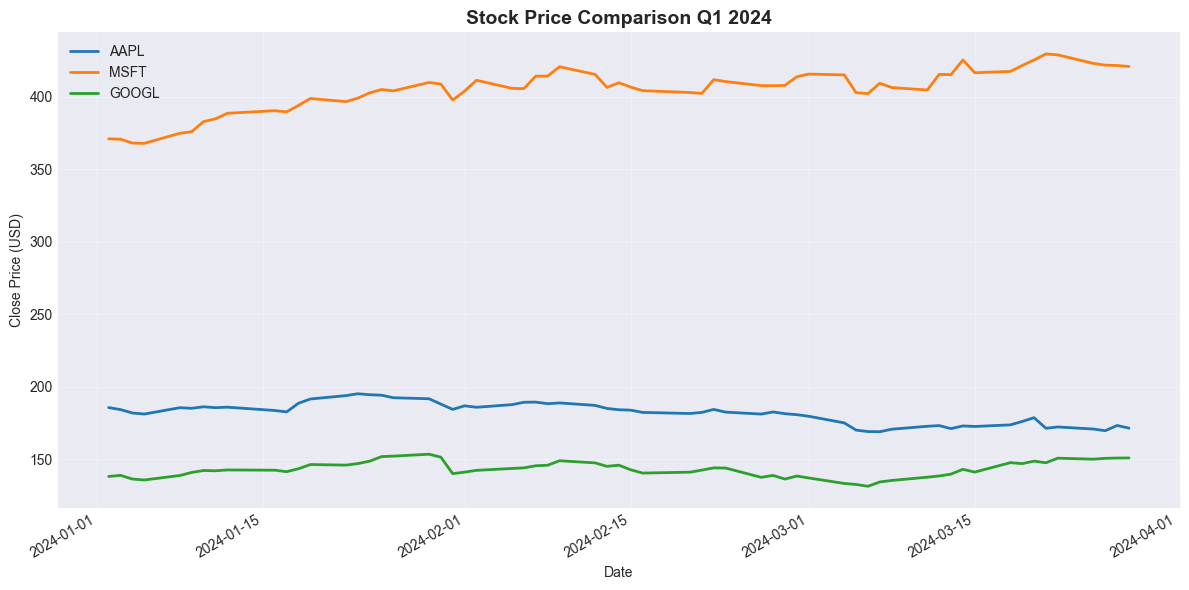

In [4]:
# Convert to pandas for easier plotting
df_pandas = df.to_pandas()

# Pivot to wide format for plotting
pivot_df = df_pandas.pivot(index="timestamp", columns="symbol", values="close")
pivot_df = pivot_df.astype(float)  # Convert Decimal to float for plotting

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for symbol in symbols:
    if symbol in pivot_df.columns:
        pivot_df[symbol].plot(ax=ax, label=symbol, linewidth=2)

ax.set_title("Stock Price Comparison Q1 2024", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Calculate Returns

Calculate daily returns for each stock.

In [5]:
# Calculate returns using Polars
df_with_returns = df.sort(["symbol", "timestamp"]).with_columns(
    [(pl.col("close") / pl.col("close").shift(1) - 1).over("symbol").alias("returns")]
)

# Convert to pandas for summary statistics
returns_df = df_with_returns.to_pandas()

# Summary statistics by symbol
print("\nReturns Summary by Symbol:")
print("-" * 60)
for symbol in symbols:
    symbol_returns = returns_df[returns_df["symbol"] == symbol]["returns"].dropna()
    print(f"\n{symbol}:")
    print(f"  Mean daily return: {symbol_returns.mean():.4%}")
    print(f"  Std deviation: {symbol_returns.std():.4%}")
    print(f"  Min return: {symbol_returns.min():.4%}")
    print(f"  Max return: {symbol_returns.max():.4%}")


Returns Summary by Symbol:
------------------------------------------------------------

AAPL:
  Mean daily return: -0.1244%


TypeError: unsupported operand type(s) for -: 'float' and 'decimal.Decimal'

## 5. Simple Mean Reversion Strategy

Implement a basic mean reversion strategy:
- Buy when price is below 20-day moving average
- Sell when price is above 20-day moving average

In [ ]:
# Calculate 20-day moving average using Polars
df_strategy = df.sort(["symbol", "timestamp"]).with_columns(
    [pl.col("close").cast(pl.Float64).rolling_mean(window_size=20).over("symbol").alias("ma_20")]
)

# Generate signals
df_strategy = df_strategy.with_columns(
    [
        pl.when(pl.col("close").cast(pl.Float64) < pl.col("ma_20"))
        .then(1)
        .when(pl.col("close").cast(pl.Float64) > pl.col("ma_20"))
        .then(-1)
        .otherwise(0)
        .alias("signal")
    ]
)

# Calculate strategy returns
df_strategy = df_strategy.with_columns(
    [
        (pl.col("close") / pl.col("close").shift(1) - 1).over("symbol").alias("returns"),
        (
            pl.col("signal").shift(1).over("symbol")
            * (pl.col("close") / pl.col("close").shift(1) - 1)
        ).alias("strategy_returns"),
    ]
)

## 6. Performance Metrics

Calculate cumulative returns for buy-and-hold vs. mean reversion strategy.

In [ ]:
# Convert to pandas for analysis
strategy_df = df_strategy.to_pandas()

# Calculate cumulative returns for each symbol
performance_results = {}

for symbol in symbols:
    symbol_data = strategy_df[strategy_df["symbol"] == symbol].copy()

    # Calculate cumulative returns
    symbol_data["cum_returns"] = (1 + symbol_data["returns"]).cumprod() - 1
    symbol_data["cum_strategy_returns"] = (
        1 + symbol_data["strategy_returns"].fillna(0)
    ).cumprod() - 1

    # Final returns
    buy_hold_return = symbol_data["cum_returns"].iloc[-1]
    strategy_return = symbol_data["cum_strategy_returns"].iloc[-1]

    performance_results[symbol] = {
        "buy_hold": buy_hold_return,
        "strategy": strategy_return,
        "outperformance": strategy_return - buy_hold_return,
    }

## 7. Visualize Strategy Performance

Plot cumulative returns for buy-and-hold vs. strategy.

In [ ]:
fig, axes = plt.subplots(len(symbols), 1, figsize=(12, 4 * len(symbols)))

if len(symbols) == 1:
    axes = [axes]

for idx, symbol in enumerate(symbols):
    symbol_data = strategy_df[strategy_df["symbol"] == symbol].copy()
    symbol_data["cum_returns"] = (1 + symbol_data["returns"]).cumprod() - 1
    symbol_data["cum_strategy_returns"] = (
        1 + symbol_data["strategy_returns"].fillna(0)
    ).cumprod() - 1

    ax = axes[idx]

    # Plot cumulative returns
    ax.plot(
        symbol_data["timestamp"],
        symbol_data["cum_returns"],
        label="Buy & Hold",
        linewidth=2,
        alpha=0.8,
    )
    ax.plot(
        symbol_data["timestamp"],
        symbol_data["cum_strategy_returns"],
        label="Mean Reversion",
        linewidth=2,
        alpha=0.8,
    )

    ax.set_title(f"{symbol} - Cumulative Returns", fontsize=12, fontweight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Intraday Data Example

Fetch hourly data for SPY (limited to 60 days).

In [ ]:
# Fetch recent hourly data (last 5 days)
end_date_intraday = pd.Timestamp.now()
start_date_intraday = end_date_intraday - pd.Timedelta(days=5)

df_intraday = await adapter.fetch(
    symbols=["SPY"], start_date=start_date_intraday, end_date=end_date_intraday, resolution="1h"
)


# Plot intraday prices
intraday_pandas = df_intraday.to_pandas()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(intraday_pandas["timestamp"], intraday_pandas["close"], linewidth=1.5)
ax.set_title("SPY Hourly Prices (Last 5 Days)", fontsize=14, fontweight="bold")
ax.set_xlabel("Date/Time")
ax.set_ylabel("Close Price (USD)")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we demonstrated:

1. ✅ Fetching stock/ETF data using YFinanceAdapter
2. ✅ Handling dividend and split data
3. ✅ Implementing a simple mean reversion strategy
4. ✅ Analyzing performance metrics
5. ✅ Fetching intraday data for shorter timeframes

## Next Steps

- Explore other data adapters (CCXT for crypto, CSV for custom data)
- Implement more sophisticated strategies
- Add transaction costs and slippage modeling
- Integrate with RustyBT's backtesting engine for full strategy testing